### Using Time Series train-test split to validate model for each location

### And also forecasting

In [113]:
import numpy as np
import geopandas as gp
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
import datetime as dt

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

Importing the .py for reading the geojson:

In [8]:
import json_to_csv

Using a sample dataset:

In [10]:
df = json_to_csv.geojson_to_csv('NASA/POWER_Point_Monthly_Timeseries_1981_2020_046d1704N_123d7804W_LST.json')
df.head()

,ALLSKY_KT,CLOUD_AMT,CLRSKY_KT,TOA_SW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SRF_ALB,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_SW_DIFF,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX
ds,,,,,,,,,,,,,,
1984-01-01,0.48,56.88,0.67,3.13,-999.0,-999.0,0.23,-999.0,1.50,2.12,-999.0,-999.0,-999.0,-999
1984-02-01,0.37,80.71,0.68,4.68,-999.0,-999.0,0.13,-999.0,1.73,3.20,-999.0,-999.0,-999.0,-999
1984-03-01,0.51,69.38,0.74,6.90,-999.0,-999.0,0.27,-999.0,3.52,5.12,-999.0,-999.0,-999.0,-999
1984-04-01,0.49,71.58,0.76,9.15,-999.0,-999.0,0.20,-999.0,4.54,6.96,-999.0,-999.0,-999.0,-999
1984-05-01,0.52,66.41,0.76,10.82,-999.0,-999.0,0.23,-999.0,5.63,8.21,-999.0,-999.0,-999.0,-999


Extracting the first column (``ALLSKY_KT``) for simplicity:

(the resetting the index part isn't necessary, I was just very confused earlier)

In [20]:
solardf = pd.DataFrame(df['ALLSKY_KT'])
solardf['date'] = solardf.index
solardf

,ALLSKY_KT,date
ds,,
1984-01-01,0.48,1984-01-01
1984-02-01,0.37,1984-02-01
1984-03-01,0.51,1984-03-01
1984-04-01,0.49,1984-04-01
1984-05-01,0.52,1984-05-01
...,...,...
2020-08-01,0.63,2020-08-01
2020-09-01,0.50,2020-09-01
2020-10-01,0.50,2020-10-01


The length of the df is as expected (444 rows), so this should be good to go.

### Creating train-test split for time series 

using sklearn TimeSeriesSplit, create train sets of increasing size (6 total splits) and a set test size (48 months, or 4 years)

In [25]:
tscv = TimeSeriesSplit(max_train_size=396, n_splits=6, test_size=48)
tscv

TimeSeriesSplit(gap=0, max_train_size=396, n_splits=6, test_size=48)

In [114]:
# defining the solar index as X

X = solardf['ALLSKY_KT']

within the for loop, the model fits to each X_train set size. I appended each MSE and r2 to arrays to see how they change as the training set increases in size.

In [107]:
MSEs = []
r2s = []

for train_index, test_index in tscv.split(X):
    #print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    model = SARIMAX(X_train, order = (6,0,3), seasonal_order = (2,0,1,12))
    model_fit = model.fit(disp = False)
    #print(model_fit.summary())
    predict = model_fit.predict(start=396, end=443)
    MSE = mean_squared_error(X_test, predict)
    r2 = r2_score(X_test, predict)
    MSEs.append([len(train_index), MSE])
    r2s.append([len(train_index), r2])

/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cbenstead

The MSEs and R2 per training set size:

(as seen with the r2 scores, this model is not very good. diff hyperparameters might be better, otherwise prophet has got a much better model)

In [108]:
MSEs

[[156, 0.005189212052388111],
 [204, 0.006200115409131869],
 [252, 0.0032407874092964368],
 [300, 0.00253782467458639],
 [348, 0.004567036435175714],
 [396, 0.0033025985481576585]]

In [109]:
r2s

[[156, -0.051904325945997476],
 [204, 0.30166865943293775],
 [252, 0.6000378070771404],
 [300, 0.6524499045853196],
 [348, 0.3017801819032777],
 [396, 0.5928978468385893]]

### Plotting the predicted values against the test set (final four years of the dataset)

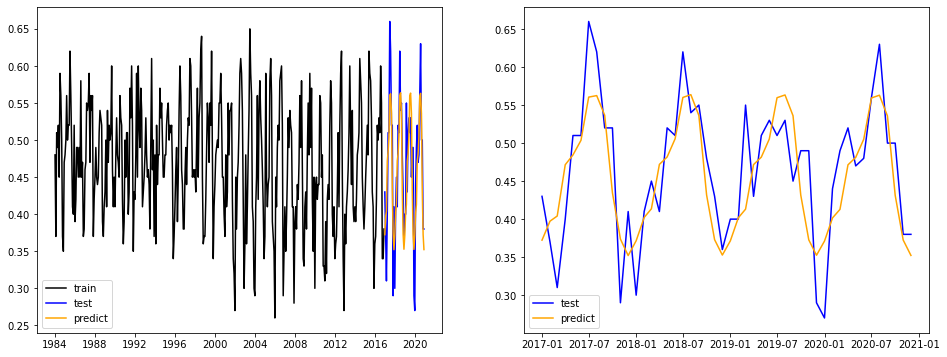

In [110]:
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(nrows=1, ncols=2)

ax[0].plot(X_train, color='black', label='train')
ax[0].plot(X_test, color='blue', label='test')
ax[0].plot(predict, color='orange', label='predict')
ax[0].legend()

ax[1].plot(X_test, color='blue', label='test')
ax[1].plot(predict, color='orange', label='predict')
ax[1].legend()


## Forecasting...I have no idea how this will work

concept: get_forecast will predict values out-of-sample range (i.e. ahead in time)

starting with get_predict to see what it does

side note: if this doesn't work at a later date, it's because I unimported SARIMAXResults

### Define the model

Doing this again so that it doesn't fit to the same model as earlier (otherwise the model would have seen all the data before)

First step is to fit the model to a subset of the data. In this case, I used the largest training set size from the time series split 

In [121]:
Y = solardf['ALLSKY_KT'][:-48]
len(Y)

396

In [122]:
mods = SARIMAX(Y, order = (6,0,3), seasonal_order = (1,0,1,12))
res_fit = mods.fit(disp = False)

print(res_fit.summary())

/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                            ALLSKY_KT   No. Observations:                  396
Model:             SARIMAX(6, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 520.632
Date:                              Wed, 09 Mar 2022   AIC                          -1017.263
Time:                                      16:52:50   BIC                           -969.486
Sample:                                  01-01-1984   HQIC                          -998.336
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       9.659e-06   3.66e-06      2.637      0.008    2.48e-06    1.68e-05
ar.L2       1.722e-

/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Next, we fit the model again with the entire dataset, but using the parameters from the training set model

In [123]:
mod = SARIMAX(X, order = (6,0,3), seasonal_order = (1,0,1,12))
res = mod.filter(res_fit.params)

/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


From there, we can predict both one-step-forward:

In [86]:
predict = res.get_prediction(end='2030-12-01')
predict_ci = predict.conf_int()

And dynamically:

(dynamic means that the model will use one-step-ahead predictions with the true previous values up until the date/index specified. After that point, it uses its own predicted values to predict the next. This allows for out-of-sample forecasting, and for predictions within the sample (we can use that to compare the model's accuracy to real values)

In [111]:
prediction = res.get_prediction(end='2030-12-01', dynamic='2019-01-01')
prediction_ci = prediction.conf_int()

### Plotting the results and confidence intervals

the ``get prediction`` function provides confidence intervals in addition to forecasted values. I only plotted the dynamic prediction because the other one had the same plot

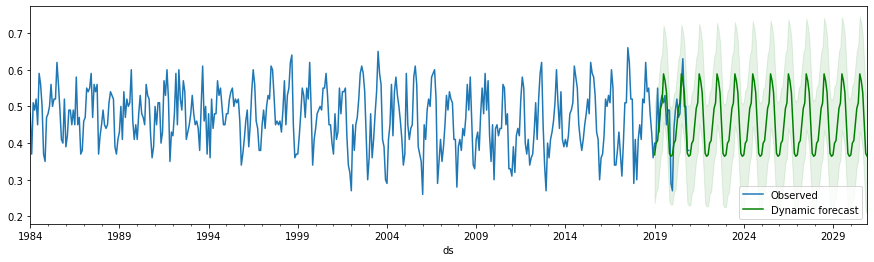

In [125]:
fig, ax = plt.subplots(figsize=(15,4))

X.plot(ax=ax, label='Observed')

prediction.predicted_mean.loc['2019-01-01':].plot(ax=ax, style='g', label='Dynamic forecast')
cix = prediction_ci.loc['2019-01-01':]
ax.fill_between(cix.index, cix.iloc[:,0], cix.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

## Trying something...

as we can see with the data, the *average* index values hasn't changed much over the years, but the magnitude of the averages have. I wonder what the absolute values plotted would look like?

In [126]:
import math

In [138]:
y = solardf['ALLSKY_KT']


In [143]:
s = pd.Series(y.values)
diff = s.diff().fillna(s)
diff

0      0.48
1     -0.11
2      0.14
3     -0.02
4      0.03
       ... 
439    0.07
440   -0.13
441    0.00
442   -0.12
443    0.00
Length: 444, dtype: float64

In [145]:
mag = abs(diff)

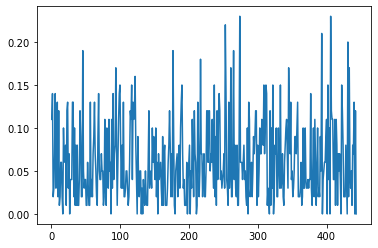

In [148]:
plt.plot(mag[1:])

yeah, idk where i'm going with this